In [ ]:
!pip install statsmodels==0.14.0

In [ ]:
!pip install catboost

In [ ]:
!pip install lightgbm

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from patsy import dmatrices

from statsmodels.api import GLM, families
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import GradientBoostingRegressor

from statsmodels.api import add_constant

import lightgbm as lgb
import time
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Load data
df1 = pd.read_csv("/content/df_train_part1_20250212.csv")
df2 = pd.read_csv("/content/df_train_part2_20250212.csv")
df = pd.concat([df1, df2], ignore_index=True)

# Rename ID column
df = df.rename(columns={'Unnamed: 0': 'ID'})

In [ ]:
# data with feature engineering
df_encoded = df.copy()

# data without feature engineering
df_encoded2 = df.copy()

# dataframe for catboost (no encoding)
df_cat = df.copy()

# feature engineering
df_encoded['CarAge_2'] = df_encoded['CarAge'] * df_encoded['CarAge']
df_encoded['CarAge_3'] = df_encoded['CarAge'] * df_encoded['CarAge'] * df_encoded['CarAge']
df_encoded['DriverAge_2'] = df_encoded['DriverAge'] * df_encoded['DriverAge']
df_encoded['DriverAge_3'] = df_encoded['DriverAge'] * df_encoded['DriverAge'] * df_encoded['DriverAge']
df_encoded['Density_2'] = df_encoded['Density'] * df_encoded['Density']
df_encoded['Density_3'] = df_encoded['Density'] * df_encoded['Density'] * df_encoded['Density']
df_encoded['CarAge_DriverAge'] = df_encoded['CarAge'] * df_encoded['DriverAge']
df_encoded['Density_DriverAge'] = df_encoded['Density'] * df_encoded['DriverAge']
df_encoded['Density_CarAge'] = df_encoded['Density'] * df_encoded['CarAge']

df_cat['CarAge_2'] = df_cat['CarAge'] * df_cat['CarAge']
df_cat['CarAge_3'] = df_cat['CarAge'] * df_cat['CarAge'] * df_cat['CarAge']
df_cat['DriverAge_2'] = df_cat['DriverAge'] * df_cat['DriverAge']
df_cat['DriverAge_3'] = df_cat['DriverAge'] * df_cat['DriverAge'] * df_cat['DriverAge']
df_cat['Density_2'] = df_cat['Density'] * df_cat['Density']
df_cat['Density_3'] = df_cat['Density'] * df_cat['Density'] * df_cat['Density']
df_cat['CarAge_DriverAge'] = df_cat['CarAge'] * df_cat['DriverAge']
df_cat['Density_DriverAge'] = df_cat['Density'] * df_cat['DriverAge']
df_cat['Density_CarAge'] = df_cat['Density'] * df_cat['CarAge']

# Create dummy variables and ensure that the first column is dropped
df_encoded = pd.get_dummies(df_encoded, columns=['Power','Brand', 'Gas', 'Region'], drop_first=True)
df_encoded2 = pd.get_dummies(df_encoded2, columns=['Power','Brand', 'Gas', 'Region'], drop_first=True)

dummy_columns = df_encoded.select_dtypes(include=['bool']).columns
dummy_columns2 = df_encoded2.select_dtypes(include=['bool']).columns

df_encoded[dummy_columns] = df_encoded[dummy_columns].astype(int)
df_encoded2[dummy_columns2] = df_encoded2[dummy_columns2].astype(int)

cols = ["CarAge", "DriverAge", "Density", "CarAge_2", "CarAge_3", "DriverAge_2", "DriverAge_3", "Density_2","Density_3", "CarAge_DriverAge", "Density_DriverAge", "Density_CarAge"]

# standardise columns
for col in cols:
  df_encoded[col] = (df_encoded[col]-df_encoded[col].mean())/df_encoded[col].std()

# Rename brand columns
df_encoded = df_encoded.rename(columns={
    'Brand_Volkswagen, Audi, Skoda or Seat': 'Brand_Volkswagen_Audi_Skoda_or_Seat',
    'Brand_Renault, Nissan or Citroen': 'Brand_Renault_Nissan_or_Citroen',
    'Brand_Japanese (except Nissan) or Korean': 'Brand_Japanese_Excl_Nissan_or_Korean',
    'Brand_Opel, General Motors or Ford': 'Brand_Opel_GeneralMotors_Ford',
    'Brand_other': 'Brand_other',
    'Brand_Mercedes, Chrysler or BMW': 'Brand_Mercedes_Chrysler_BMW',
    'Brand_Fiat': 'Brand_Fiat'
})

df_encoded2 = df_encoded2.rename(columns={
    'Brand_Volkswagen, Audi, Skoda or Seat': 'Brand_Volkswagen_Audi_Skoda_or_Seat',
    'Brand_Renault, Nissan or Citroen': 'Brand_Renault_Nissan_or_Citroen',
    'Brand_Japanese (except Nissan) or Korean': 'Brand_Japanese_Excl_Nissan_or_Korean',
    'Brand_Opel, General Motors or Ford': 'Brand_Opel_GeneralMotors_Ford',
    'Brand_other': 'Brand_other',
    'Brand_Mercedes, Chrysler or BMW': 'Brand_Mercedes_Chrysler_BMW',
    'Brand_Fiat': 'Brand_Fiat'
})

# Rename region columns
df_encoded = df_encoded.rename(columns={
    'Region_Basse-Normandie': 'Region_Basse_Normandie',
    'Region_Bretagne': 'Region_Bretagne',
    'Region_Centre': 'Region_Centre',
    'Region_Haute-Normandie': 'Region_Haute_Normandie',
    'Region_Ile-de-France': 'Region_Ile_de_France',
    'Region_Limousin': 'Region_Limousin',
    'Region_Nord-Pas-de-Calais': 'Region_Nord_Pas_de_Calais',
    'Region_Pays-de-la-Loire': 'Region_Pays_de_la_Loire',
    'Region_Poitou-Charentes': 'Region_Poitou_Charentes'
})

df_encoded2 = df_encoded2.rename(columns={
    'Region_Basse-Normandie': 'Region_Basse_Normandie',
    'Region_Bretagne': 'Region_Bretagne',
    'Region_Centre': 'Region_Centre',
    'Region_Haute-Normandie': 'Region_Haute_Normandie',
    'Region_Ile-de-France': 'Region_Ile_de_France',
    'Region_Limousin': 'Region_Limousin',
    'Region_Nord-Pas-de-Calais': 'Region_Nord_Pas_de_Calais',
    'Region_Pays-de-la-Loire': 'Region_Pays_de_la_Loire',
    'Region_Poitou-Charentes': 'Region_Poitou_Charentes'
})

print(df_encoded.columns)
df_encoded.head()

Index(['ID', 'ClaimNb', 'Exposure', 'CarAge', 'DriverAge', 'Density',
       'ClaimAmount', 'PurePremium', 'CarAge_2', 'CarAge_3', 'DriverAge_2',
       'DriverAge_3', 'Density_2', 'Density_3', 'CarAge_DriverAge',
       'Density_DriverAge', 'Density_CarAge', 'Power_e', 'Power_f', 'Power_g',
       'Power_h', 'Power_i', 'Power_j', 'Power_k', 'Power_l', 'Power_m',
       'Power_n', 'Power_o', 'Brand_Japanese_Excl_Nissan_or_Korean',
       'Brand_Mercedes_Chrysler_BMW', 'Brand_Opel_GeneralMotors_Ford',
       'Brand_Renault_Nissan_or_Citroen',
       'Brand_Volkswagen_Audi_Skoda_or_Seat', 'Brand_other', 'Gas_Regular',
       'Region_Basse_Normandie', 'Region_Bretagne', 'Region_Centre',
       'Region_Haute_Normandie', 'Region_Ile_de_France', 'Region_Limousin',
       'Region_Nord_Pas_de_Calais', 'Region_Pays_de_la_Loire',
       'Region_Poitou_Charentes'],
      dtype='object')


,ID,ClaimNb,Exposure,CarAge,DriverAge,Density,ClaimAmount,PurePremium,CarAge_2,CarAge_3,...,Gas_Regular,Region_Basse_Normandie,Region_Bretagne,Region_Centre,Region_Haute_Normandie,Region_Ile_de_France,Region_Limousin,Region_Nord_Pas_de_Calais,Region_Pays_de_la_Loire,Region_Poitou_Charentes
0,044049e5-3107-4e9f-9a58-a4009f9c047f,0,0.48,-0.093590,0.397590,0.449322,0.0,0.0,-0.251682,-0.094456,...,1,0,0,0,0,0,0,0,1,0
1,03d2a0f5-bf53-4926-ad50-547ae1bbf5f6,0,1.00,0.946167,0.118497,-0.389037,0.0,0.0,0.482226,0.068314,...,1,0,0,1,0,0,0,0,0,0
2,0f7d922f-214e-4220-8870-bc7c4ab8e5d6,1,0.40,0.252996,-0.021050,5.243058,1116.0,2790.0,-0.055973,-0.060567,...,1,0,0,0,0,1,0,0,0,0
3,ddffa04f-b503-42fa-8c8c-1ef42d8fda82,0,0.58,-0.613468,-0.928105,-0.247774,0.0,0.0,-0.453507,-0.118950,...,0,0,0,0,0,0,0,1,0,0
4,b68cce4b-34b1-4e26-96d8-2219f280b382,0,0.52,0.599582,-1.276972,-0.310022,0.0,0.0,0.188663,-0.007715,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
########## data with feature engineering #############
X = df_encoded.drop(["ID", "ClaimAmount", "ClaimNb", "PurePremium"], axis = 1)
y = df_encoded["ClaimNb"]/df_encoded["Exposure"]

# split data into train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

########## data without feature engineering #############
X2 = df_encoded2.drop(["ID", "ClaimAmount", "ClaimNb", "PurePremium"], axis = 1)
y2 = df_encoded2["ClaimNb"]/df_encoded2["Exposure"]

# split data into train, test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=42)

########## data for catboost #############
X3 = df_cat.drop(["ID", "ClaimAmount", "ClaimNb", "PurePremium"], axis = 1)
y3 = df_cat["ClaimNb"]/df_cat["Exposure"]

# split data into train, test
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.20, random_state=42)

# Frequency

## Catboost

In [ ]:
# further split train to train, val
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(X_train3, y_train3, test_size=0.20, random_state=42)

In [ ]:
train_pool = Pool(
    X_train_cat.drop("Exposure", axis = 1),
    label = y_train_cat,
    cat_features = [col for col in X_train_cat.columns if X_train_cat[col].dtype == 'object' and col != "Exposure"]

)

val_pool = Pool(
    X_val_cat.drop("Exposure", axis = 1),
    label = y_val_cat,
    cat_features = [col for col in X_val_cat.columns if X_val_cat[col].dtype == 'object' and col != "Exposure"]

)

test_pool = Pool(
    X_test3.drop("Exposure", axis = 1),
    label = y_test3,
    cat_features = [col for col in X_test3.columns if X_train3[col].dtype == 'object' and col != "Exposure"]

)

In [ ]:
# fit a catboost model
########################### Set random seed here ################################
start_catboost_train = time.time()
model_cat = CatBoostRegressor(objective = "Poisson", iterations = 1000,
                              learning_rate = 0.01, depth = 8, verbose = 500, random_seed = 42)
model_cat.fit(train_pool, plot = True, eval_set = val_pool, verbose = 500)
end_catboost_train = time.time()
catboost_train_time = end_catboost_train - start_catboost_train

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.9812913	test: 0.9813637	best: 0.9813637 (0)	total: 339ms	remaining: 5m 38s
500:	learn: 0.3367204	test: 0.3674566	best: 0.3673144 (481)	total: 2m 16s	remaining: 2m 15s
999:	learn: 0.3204330	test: 0.3689792	best: 0.3673144 (481)	total: 4m 21s	remaining: 0us

bestTest = 0.3673144384
bestIteration = 481

Shrink model to first 482 iterations.


In [ ]:
cat_freq = model_cat.predict(test_pool)

print("\nPredicted frequency for the first ")
print(f"R^2: {round(r2_score(y_test3, cat_freq),7)}")
print(f"MSE: {round(mean_squared_error(y_test3, cat_freq),7)}")
print(f"MAE: {round(mean_absolute_error(y_test3, cat_freq),7)}")


Predicted frequency for the first 
R^2: -0.0001415
MSE: 4.7894211
MAE: 0.2262257


# Severity

## Gamma model


**Gamma model is fitted on the original features <u>without</u> feature engineering**

In [ ]:
############### this data is not used for gamma model, but it's for lightgbm ###############
# outcome: severity
y_gamma = df_encoded.apply(lambda row: 0 if row["ClaimNb"] == 0 else row["ClaimAmount"]/row["ClaimNb"], axis = 1)
X_gamma = df_encoded.drop(["ID", "Exposure", "ClaimAmount","PurePremium"], axis = 1)
X_train_gamma, X_test_gamma, y_train_gamma, y_test_gamma = train_test_split(X_gamma, y_gamma, test_size=0.20, random_state=42)

## Lightgbm

In [ ]:
# split data into train, test
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(X_gamma, y_gamma, test_size=0.20, random_state=42)
X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(X_train_lgb, y_train_lgb, test_size=0.20, random_state=42)

In [ ]:
# model 1
nonzero_lgb1 = (y_train_lgb > 0)
nonzero_lgb_val1 = (y_val_lgb > 0)

train_data1 = lgb.Dataset(X_train_lgb.drop("ClaimNb", axis = 1).loc[nonzero_lgb1,:], label=y_train_lgb[nonzero_lgb1])
val_data1 = lgb.Dataset(X_val_lgb.drop("ClaimNb", axis = 1).loc[nonzero_lgb_val1,:], label=y_val_lgb[nonzero_lgb_val1])
test_data1 = lgb.Dataset(X_test_lgb.drop("ClaimNb", axis = 1), label = y_test_gamma)

In [ ]:
# specify parameters
params_lgb1 = {
    'learning_rate': 0.001,
    'n_estimators': 75,
    'num_leaves': 25,
    "objective": "gamma",
}

# train the first model
########################### Set random seed here ################################
start_lgb1 = time.time()
model_lgb1 = lgb.train(
    params_lgb1,
    train_data1,
    valid_sets = [val_data1],
    num_boost_round = 500
)
end_lgb1 = time.time()
lgb_train_time = end_lgb1 - start_lgb1
pred_lgb1 = model_lgb1.predict(X_test.drop("Exposure", axis = 1))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 7864, number of used features: 39
[LightGBM] [Info] Start training from score 7.718742


# Final Prediction

In [ ]:
######## true values #########
purepremium = df_encoded.loc[X_test.index, "PurePremium"]
######## predicted values #########
# 22th model (refer to googlesheets) with gamma
purepremium_pred1 = cat_freq * pred_lgb1

In [ ]:
# print final result
print("Model22, with gamma in lgb")
print(f"R^2: {round(r2_score(purepremium, purepremium_pred1),7)}")
print(f"MSE: {round(mean_squared_error(purepremium, purepremium_pred1),7)}")
print(f"MAE: {round(mean_absolute_error(purepremium, purepremium_pred1),7)}")
print(f"Total Training time: {round(catboost_train_time + lgb_train_time,2)} seconds")

Model22, with gamma in lgb
R^2: -5.15e-05
MSE: 118863223.1769956
MAE: 519.0587694
Total Training time: 262.9 seconds


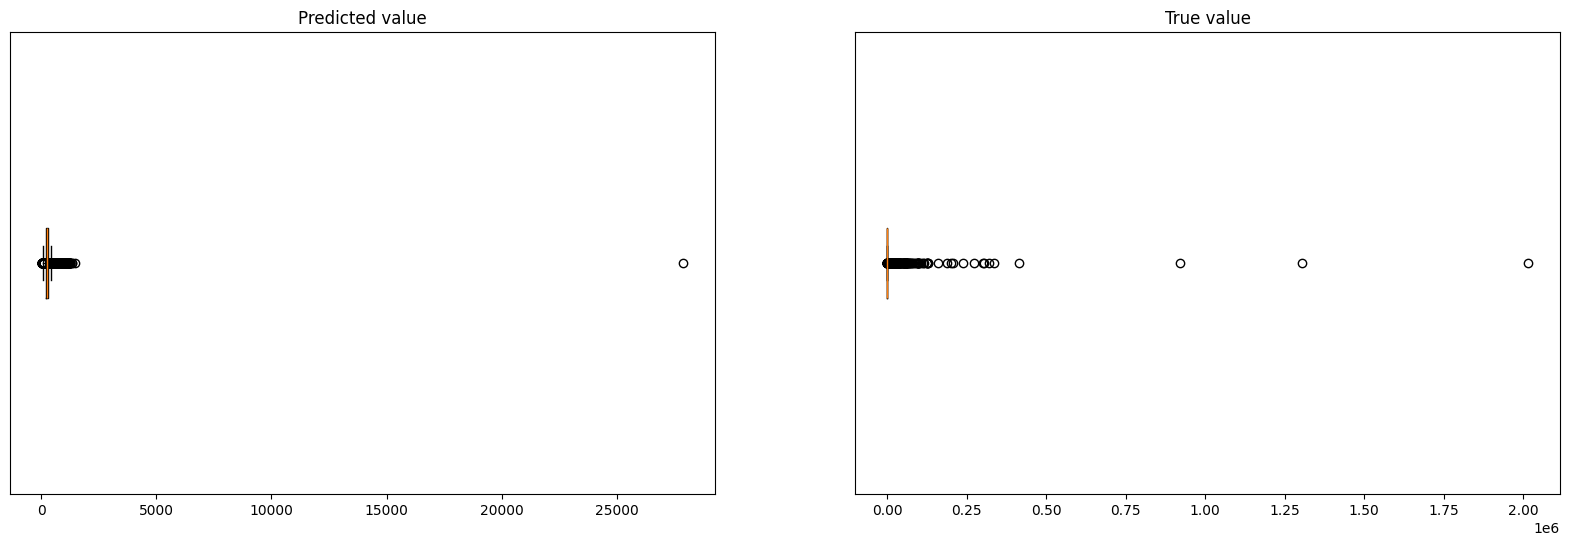

In [ ]:
########### Box plots for model 22 with gamma in lgb ###########

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Predicted value plot
ax[0].set_title("Predicted value")
ax[0].boxplot(purepremium_pred1, vert=False)
ax[0].tick_params(axis="y", left=False)  # Hide y-axis ticks for the first plot
# ax[0].set_xlim(0,500)
ax[0].set_yticklabels([])

# True value plot
ax[1].set_title("True value")
ax[1].boxplot(purepremium, vert=False)
ax[1].tick_params(axis="y", left=False)  # Hide y-axis ticks for the second plot
ax[1].set_yticklabels([])

plt.show()


In [ ]:
# Load holdout dataset
holdout_df = pd.read_csv("X_holdout_20250212.csv")

# Extract ID column
ids = holdout_df.iloc[:, 0]  # First column is ID

# Select only feature columns (excluding ID)
X_holdout_cat = holdout_df.iloc[:, 1:].copy()  # For CatBoost (raw categorical)
X_holdout_lgb = X_holdout_cat.copy()  # Copy for LightGBM (dummy-encoded)

### ---- Feature Engineering for Both Versions ---- ###
for df in [X_holdout_cat, X_holdout_lgb]:
    df['CarAge_2'] = df['CarAge'] ** 2
    df['CarAge_3'] = df['CarAge'] ** 3
    df['DriverAge_2'] = df['DriverAge'] ** 2
    df['DriverAge_3'] = df['DriverAge'] ** 3
    df['Density_2'] = df['Density'] ** 2
    df['Density_3'] = df['Density'] ** 3
    df['CarAge_DriverAge'] = df['CarAge'] * df['DriverAge']
    df['Density_DriverAge'] = df['Density'] * df['DriverAge']
    df['Density_CarAge'] = df['Density'] * df['CarAge']

### ---- Standardization for Both Versions ---- ###
cols_to_standardize = ["CarAge", "DriverAge", "Density", "CarAge_2", "CarAge_3",
                       "DriverAge_2", "DriverAge_3", "Density_2", "Density_3",
                       "CarAge_DriverAge", "Density_DriverAge", "Density_CarAge"]

for df in [X_holdout_cat, X_holdout_lgb]:
    for col in cols_to_standardize:
        df[col] = (df[col] - df[col].mean()) / df[col].std()

### ---- Dummy Encoding for LightGBM Version ---- ###
X_holdout_lgb = pd.get_dummies(X_holdout_lgb, columns=['Power', 'Brand', 'Gas', 'Region'], drop_first=True)

# Convert dummy variables to int
dummy_columns = X_holdout_lgb.select_dtypes(include=['bool']).columns
X_holdout_lgb[dummy_columns] = X_holdout_lgb[dummy_columns].astype(int)

### ---- Rename Columns to Match Training Data (LightGBM) ---- ###
X_holdout_lgb = X_holdout_lgb.rename(columns={
    'Brand_Volkswagen, Audi, Skoda or Seat': 'Brand_Volkswagen_Audi_Skoda_or_Seat',
    'Brand_Renault, Nissan or Citroen': 'Brand_Renault_Nissan_or_Citroen',
    'Brand_Japanese (except Nissan) or Korean': 'Brand_Japanese_Excl_Nissan_or_Korean',
    'Brand_Opel, General Motors or Ford': 'Brand_Opel_GeneralMotors_Ford',
    'Brand_other': 'Brand_other',
    'Brand_Mercedes, Chrysler or BMW': 'Brand_Mercedes_Chrysler_BMW',
    'Brand_Fiat': 'Brand_Fiat',
    'Region_Basse-Normandie': 'Region_Basse_Normandie',
    'Region_Bretagne': 'Region_Bretagne',
    'Region_Centre': 'Region_Centre',
    'Region_Haute-Normandie': 'Region_Haute_Normandie',
    'Region_Ile-de-France': 'Region_Ile_de_France',
    'Region_Limousin': 'Region_Limousin',
    'Region_Nord-Pas-de-Calais': 'Region_Nord_Pas_de_Calais',
    'Region_Pays-de-la-Loire': 'Region_Pays_de_la_Loire',
    'Region_Poitou-Charentes': 'Region_Poitou_Charentes'
})

### ---- Predict Frequency Using CatBoost (df_cat) ---- ###
cat_freq = model_cat.predict(X_holdout_cat)

### ---- Predict Severity Using LightGBM (df_encoded) ---- ###
# Predict severity
pred_lgb1 = model_lgb1.predict(X_holdout_lgb)

### ---- Calculate Pure Premium ---- ###
purepremium_pred = cat_freq * pred_lgb1


In [ ]:
# Number of bootstrap samples
n_bootstrap = 1000

# Store bootstrap predictions
bootstrap_preds = []

for _ in range(n_bootstrap):
    # Resample the holdout set with replacement
    X_holdout_boot = X_holdout_cat.sample(frac=1, replace=True, random_state=_)
    X_holdout_lgb_boot = X_holdout_lgb.loc[X_holdout_boot.index].copy()

    # Predict frequency and severity for bootstrap sample
    cat_freq_boot = model_cat.predict(X_holdout_boot)
    pred_lgb_boot = model_lgb1.predict(X_holdout_lgb_boot)

    # Compute pure premium
    purepremium_boot = cat_freq_boot * pred_lgb_boot
    bootstrap_preds.append(purepremium_boot)

# Convert bootstrap results to DataFrame
bootstrap_preds = np.array(bootstrap_preds).T  # Transpose to get shape (n_samples, n_bootstrap)

# Compute predictive intervals (5th and 95th percentiles)
lower_bound = np.percentile(bootstrap_preds, 5, axis=1)
upper_bound = np.percentile(bootstrap_preds, 95, axis=1)

# Create final output DataFrame
output_df = pd.DataFrame({
    "ID": ids,
    "Predicted_PurePremium": purepremium_pred,
    "Lower_Bound": lower_bound,
    "Upper_Bound": upper_bound
})

# Save to CSV
output_df.to_csv("predicted_pure_premium_with_intervals.csv", index=False)

print("Prediction with intervals complete! Results saved as 'predicted_pure_premium_with_intervals.csv'.")


Prediction with intervals complete! Results saved as 'predicted_pure_premium_with_intervals.csv'.
